"""
 - data from https://www.kaggle.com/c/indoor-location-navigation
 - data conversion using main_interp_wtime.py based on time of the wifi recordings 
 - these area every 2.2-2.5 seconds, and their position is intyerpolated linearily assuming constant speed between waypoints 
 - BLE beacons are attached to the closes interpolated point 
 - actual waypoint in the data ay not appear in the json produced
"""

indoor_comp_import.png - example of resulted points (blue) 


In [1]:
from utils import *
import sys, os, random

datadir = "../data.upb/uji/"


In [225]:
uji3_fnames=[
"01/3.0uji_month01_trn01.json",
"01/3.0uji_month01_trn02.json",
"01/3.0uji_month01_trn03.json",
"01/3.0uji_month01_trn04.json",
"01/3.0uji_month01_trn05.json",
"01/3.0uji_month01_trn06.json",
"01/3.0uji_month01_trn07.json",
"01/3.0uji_month01_trn08.json",
"01/3.0uji_month01_trn09.json",
"01/3.0uji_month01_trn10.json",
"01/3.0uji_month01_trn11.json",
"01/3.0uji_month01_trn12.json",
"01/3.0uji_month01_trn13.json",
"01/3.0uji_month01_trn14.json",
"01/3.0uji_month01_trn15.json",
"02/3.0uji_month02_trn01.json",
"03/3.0uji_month03_trn01.json",
"04/3.0uji_month04_trn01.json",
"05/3.0uji_month05_trn01.json",
"06/3.0uji_month06_trn01.json",
"07/3.0uji_month07_trn01.json",
"08/3.0uji_month08_trn01.json",
"09/3.0uji_month09_trn01.json",
"10/3.0uji_month10_trn01.json",
"11/3.0uji_month11_trn01.json"]
uji3_fnames2=[
"12/3.0uji_month12_trn01.json",
"13/3.0uji_month13_trn01.json",
"14/3.0uji_month14_trn01.json",
"15/3.0uji_month15_trn01.json",
"16/3.0uji_month16_trn01.json",
"17/3.0uji_month17_trn01.json",
"18/3.0uji_month18_trn01.json",
"19/3.0uji_month19_trn01.json",
"20/3.0uji_month20_trn01.json",
"21/3.0uji_month21_trn01.json",
"22/3.0uji_month22_trn01.json",
"23/3.0uji_month23_trn01.json",
"24/3.0uji_month24_trn01.json",
"25/3.0uji_month25_trn01.json",
"25/3.0uji_month25_trn02.json"
]

uji5_fnames=[
"01/5.0uji_month01_trn01.json",
"01/5.0uji_month01_trn02.json",
"01/5.0uji_month01_trn03.json",
"01/5.0uji_month01_trn04.json",
"01/5.0uji_month01_trn05.json",
"01/5.0uji_month01_trn06.json",
"01/5.0uji_month01_trn07.json",
"01/5.0uji_month01_trn08.json",
"01/5.0uji_month01_trn09.json",
"01/5.0uji_month01_trn10.json",
"01/5.0uji_month01_trn11.json",
"01/5.0uji_month01_trn12.json",
"01/5.0uji_month01_trn13.json",
"01/5.0uji_month01_trn14.json",
"01/5.0uji_month01_trn15.json",
"02/5.0uji_month02_trn01.json",
"03/5.0uji_month03_trn01.json",
"04/5.0uji_month04_trn01.json",
"05/5.0uji_month05_trn01.json",
"06/5.0uji_month06_trn01.json",
"07/5.0uji_month07_trn01.json",
"08/5.0uji_month08_trn01.json",
"09/5.0uji_month09_trn01.json",
"10/5.0uji_month10_trn01.json",
"11/5.0uji_month11_trn01.json",
"12/5.0uji_month12_trn01.json",
"13/5.0uji_month13_trn01.json",
"14/5.0uji_month14_trn01.json",
"15/5.0uji_month15_trn01.json",
"16/5.0uji_month16_trn01.json",
"17/5.0uji_month17_trn01.json",
"18/5.0uji_month18_trn01.json",
"19/5.0uji_month19_trn01.json",
"20/5.0uji_month20_trn01.json",
"21/5.0uji_month21_trn01.json",
"22/5.0uji_month22_trn01.json",
"23/5.0uji_month23_trn01.json",
"24/5.0uji_month24_trn01.json",
"25/5.0uji_month25_trn01.json",
"25/5.0uji_month25_trn02.json"
]

In [226]:

uji3 = []
for e in uji3_fnames: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    uji3.append(etaj)

uji5 = []
for e in uji5_fnames: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    uji5.append(etaj)

for e in uji3:
    for c in e:
        precalculate(c)
for e in uji5:
    for c in e:
        precalculate(c)
        
cntw = []
for r in uji3:
    for p in range(0, len(r)): 
        cntw.append(len(r[p]['ufingerprint']['wifirssi'].keys()))
print("APs per point = ", np.percentile(cntw, [50, 95]))        
print(f"uji3 = {len(uji3)} uji5 = {len(uji5)}")        
    

APs per point =  [25. 45.]
uji3 = 25 uji5 = 40


In [227]:
import numpy as np
from scipy.spatial.distance import braycurtis
from scipy.stats import ks_2samp, chisquare
import copy 


def precalculate(c): # c is a collection
    """ creates new fields to speed up distance comparisons 
          c.ufingerprint['wifirssi'][mac] = average dBm 
    """
    ufingerprint = {}
    ufingerprint['wifirssi'] = {}
    for f in c['fingerprints']:
        if not "wifi" in f.keys():
            continue
        for mac in f["wifi"].keys():
            avg_pow = np.average(f["wifi"][mac]['rssi']) # each fingerprint (direction) counts the same
            if not mac in ufingerprint["wifirssi"].keys():
                ufingerprint["wifirssi"][mac] = [avg_pow] 
            else:
                ufingerprint["wifirssi"][mac].append(avg_pow)
    for mac in ufingerprint["wifirssi"].keys():
        ufingerprint["wifirssi"][mac] = \
            np.average(adjust_rssi(ufingerprint["wifirssi"][mac])) #each fingerprint (direction) counts the same
    c['ufingerprint'] = ufingerprint
                
def merge_wifi_fingerprints1(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint

def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    # precalculated with average, adjust_rssi  
    wifi1 = c1['ufingerprint']['wifirssi']
    wifi2 = c2['ufingerprint']['wifirssi']      
    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1.0

    if len(common_aps) * 5 <= len(wifi1.keys()) or len(common_aps) < 3:
        return 1.0

    aps1 = set(wifi1.keys()) - set(common_aps)
    aps2 = set(wifi2.keys()) - set(common_aps)
    rssi1 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    rssi2 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    nap = 0   #  
    
    if selection == 'First':
        for ap in common_aps:
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
    if selection == 'Average':
        for ap in common_aps:
            rssi1[nap] = wifi1[ap]
            rssi2[nap] = wifi2[ap]
            nap = nap + 1
            
    if selection == 'Median':
        for ap in common_aps:
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Mean':
        for ap in common_aps:
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Std':
        for ap in common_aps:
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Max':
        for ap in common_aps:
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
    if selection == 'KS':
        for ap in common_aps:
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

    if (dif == True) and (selection != 'KS'):
        if len(rssi1) > nap:
            rssi1[nap] = rssi1[0]
            rssi2[nap] = rssi2[0]
        rssi1 = np.diff(rssi1, append=rssi1[0])
        rssi2 = np.diff(rssi2, append=rssi1[0])   

   
    """
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps2)))        
    iou = len(common_aps) / \
        (len(aps1) + len(aps2) + len(common_aps))
    """
        
    for ap in aps1:
        rssi1[nap] = 1.0*wifi1[ap]
        rssi2[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
    for ap in aps2:
        rssi2[nap] = 1.0*wifi2[ap]
        rssi1[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
        
    return simil_method(rssi1, rssi2)



In [238]:
# test all points on a floor versus randomly chosen points, retain only ones under 20m
# results ~ 8000 points 

before = datetime.datetime.now()
bd = []

print ("uji3 = ", len(uji3))

for r in uji3:
    for point in range(0, len(r)): 
        for p in range(0, len(r)):
            if p < point: 
                continue 
            eu_dist = euclidean([r[point]['x'], r[point]['y'], r[point]['z']], 
                                    [r[p]['x'], r[p]['y'], r[p]['z']]) 
            if eu_dist < 8.0: 
                bd.append([ point, p, eu_dist, 
                    compare_locations(r[point], r[p], dif=False)])

after = datetime.datetime.now()
print(f"{len(bd)} pairs in {(after-before).seconds} seconds")

uji3 =  25
17200 pairs in 5 seconds


Slope = [0.07009607 0.17868736]


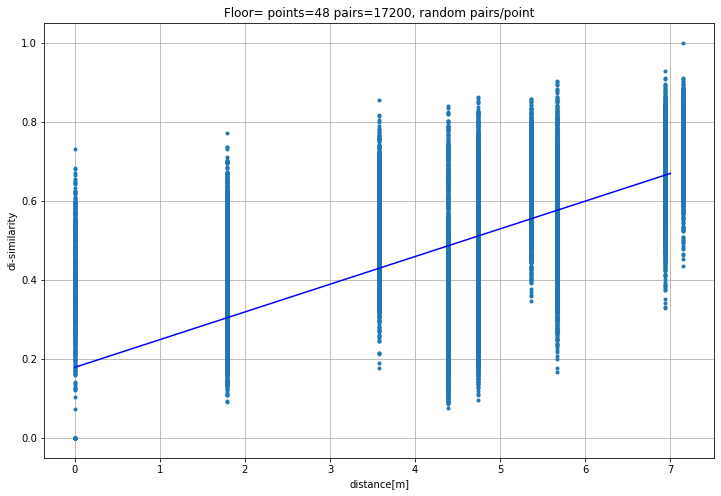

In [239]:
fig =  plt.figure(figsize=(12, 8))        
plt.plot( [r[2] for r in bd], [r[3] for r in bd], ".", label='uji3')

m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 1)
print(f"Slope = {m}")
predict = np.poly1d(m)
x_lin_reg = range(0, 8)
y_lin_reg = predict(x_lin_reg)
plt.plot(x_lin_reg, y_lin_reg, c = 'b')
   
plt.xlabel('distance[m]')
plt.ylabel('di-similarity')
plt.grid(True)
plt.title(f"Floor= points={len(uji3[0])} pairs={len(bd)}, random pairs/point")
#plt.xticks(range(0, 10))
#plt.yticks(np.arange(0, 1.1, 0.1))
#plt.legend(loc="upper right",shadow=True, fancybox=True)
plt.show()
#fig.savefig(f"Braycurtis_vs_dist_floor{len(etaje)}_8000pts.pdf", bbox_inches='tight')

datasets UJI3 first 25 + last 15 together:
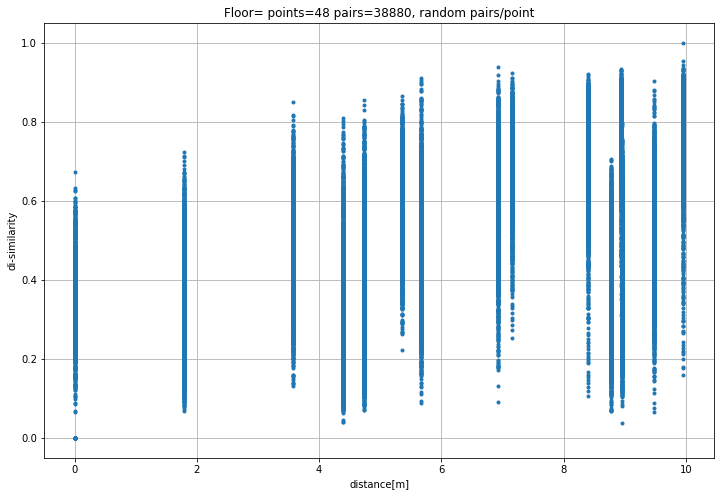


In [237]:

# test point along time 

points = range(0, len(uji3)) # this point is tested at different times   
before = datetime.datetime.now()
bd = []
similarities=np.zeros([len(uji3), len(uji3)])
for q in range(0, len(uji3)):
    for r in range(0, len(uji3)):
        if r > q:
            for p in points:  
                #print(r, uji3[r][p]['fingerprints'][0]['timestamp'])
                eu_dist = euclidean([uji3[r][p]['x'], uji3[r][p]['y'], uji3[r][p]['z']], 
                                        [uji3[q][p]['x'], uji3[q][p]['y'], uji3[q][p]['z']]) 
                disim = compare_locations(uji3[r][p], uji3[q][p], dif=False)
                bd.append([ q, r, eu_dist, disim])
                similarities[q, r] = disim; 
                similarities[r, q] = disim; 

print(np.percentile([r[3] for r in bd], [5, 50, 95]))
#print(bd)

[0.09956178 0.21602152 0.38305453]


fit = [-0.00959117  0.04237638], pos size=25


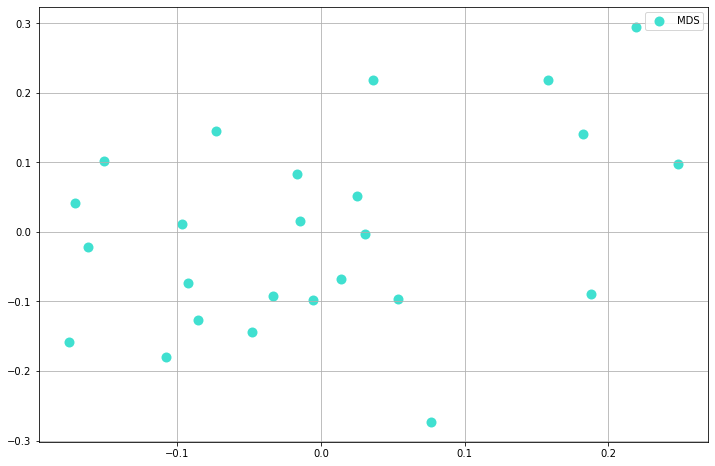

In [231]:
# map pairwise distances with MDS 
# visualise clusters in 2D 

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=13, 
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_


news = euclidean_distances(pos)

print(f"fit = {np.percentile(news - similarities, [50, 95])}, pos size={np.size(pos, 0)}")

fig = plt.figure(figsize=(12, 8))
plt.grid(True)
#ax = plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
#plt.scatter(npos[:, 0], npos[:, 1], color='darkorange', s=s, lw=0, label='NMDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)
plt.show()
